# Unidad 6: Regresión en series de tiempo

## 6.1 Introducción

Combinaremos modelos causales con datos de series de tiempo, a través de algoritmos de aprendizaje estadístico.

## 6.2 Objetivo

Combinar métodos autorregresivos y de aprendizaje estadístico mediante el enfoque de la clasificación para analizar datos de series de tiempo.

## 6.3 Acción

Esta vez deberás aplicar el algoritmo Facebook´s Prophet, y si es viable la justificación para la variable en serie de tiempo vista como una regresión. Esto último, complementa los modelos planteados anteriormente y el ajujste a un modelo lineal y estacionario.

### 6.3.1 Preparación de los datos

Previo al análisis detallado, es imperativo comprender el proceso de preparación de datos temporales para garantizar su idoneidad y coherencia en el estudio.
cia en el estudio.

In [1]:
# importando librerias

# librerias para la transformación de datos
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# libreria para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

#### 6.3.1.1 Recopilación de los datos

En este bloque, se carga el conjunto de datos desde un archivo CSV utilizando la biblioteca pandas. Se especifica el delimitador de campos y se visualizan las primeras filas del dataframe para verificar que los datos se han cargado correctamente.

In [2]:
# recopilación de datos
df_data = pd.read_csv('./dataset.csv',sep=';')
df_data.head()

,fechaoperacion,codigo,contenido,hora1,hora2,hora3,hora4,hora5,hora6,hora7,...,hora15,hora16,hora17,hora18,hora19,hora20,hora21,hora22,hora23,hora24
0,1/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),87.778212,77.778212,77.778212,77.778212,77.778212,77.778212,75.768212,...,75.768212,71.278212,69.067212,76.278212,77.778212,87.778212,87.778212,77.778212,77.778212,77.778212
1,2/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),76.278212,76.278212,76.278212,76.278212,76.278212,76.778212,76.778212,...,82.778212,82.778212,82.778212,81.768212,87.778212,87.778212,87.778212,82.778212,76.778212,76.778212
2,3/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,77.678212,...,82.778212,82.778212,82.778212,82.778212,87.778212,114.425212,87.778212,82.778212,77.678212,77.678212
3,4/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,77.778212,...,77.778212,77.778212,77.778212,85.778212,85.778212,87.778212,85.778212,85.778212,81.768212,77.778212
4,5/01/2006,PBNA,PRECIO DE BOLSA NACIONAL ($/KWH),86.778212,86.778212,86.778212,86.778212,86.778212,86.778212,88.278212,...,88.278212,88.278212,88.278212,88.278212,88.278212,91.134212,88.278212,88.278212,86.778212,86.778212


#### 6.3.1.2 Transformación de Datos

Este bloque define una función para transformar el dataframe original. Se realiza una copia del dataframe, se convierte la columna de fechas a un formato de fecha adecuado, y se agregan nuevas columnas para el año, mes y día. Luego, se seleccionan y reorganizan las columnas, y finalmente, se pivotea la tabla para facilitar su uso en análisis posteriores.

In [3]:
def trf_data(df_data):
    
    # copia del dataframe
    df = df_data.copy()
    
    # transformación de fechas
    df['fechaoperacion'] = pd.to_datetime(df['fechaoperacion'], format='%d/%m/%Y')
    
    # agregando las columnas de fechas
    df['ano'] = df.apply(lambda x: x['fechaoperacion'].year ,axis=1)
    df['mes'] = df.apply(lambda x: x['fechaoperacion'].month ,axis=1)
    df['dia'] = df.apply(lambda x: x['fechaoperacion'].day ,axis=1)
    
    # selección de columnas
    df = df[['fechaoperacion','ano','mes','dia', 'hora1', 'hora2', 'hora3','hora4', 'hora5', 'hora6', 'hora7', 'hora8', 'hora9', 'hora10','hora11', 'hora12', 'hora13', 'hora14', 'hora15', 'hora16', 'hora17','hora18', 'hora19', 'hora20', 'hora21', 'hora22', 'hora23', 'hora24']]
    
    # Convertir la tabla
    list_id = [i.lower() for i in df.columns if not 'hora' in i]
    list_value = [i.lower() for i in df.columns if 'hora' in i]
    
    # pivotear la tabla
    df = df.melt(id_vars=list_id,value_vars=list_value,var_name='periodo',value_name='valor')
    
    return df

In [4]:
# dataset trasnformado
df = trf_data(df_data)
df.head()

,fechaoperacion,ano,mes,dia,periodo,valor
0,2006-01-01,2006,1,1,hora1,87.778212
1,2006-01-02,2006,1,2,hora1,76.278212
2,2006-01-03,2006,1,3,hora1,77.678212
3,2006-01-04,2006,1,4,hora1,77.778212
4,2006-01-05,2006,1,5,hora1,86.778212


#### 6.3.1.3 Remuestreo de la serie temporal

En este bloque, se crea una copia del dataframe transformado y se remuestrean los datos a valores mensuales. Se agrupan los datos por fecha y se calcula la media mensual. Luego, se seleccionan las columnas relevantes y se visualiza el nuevo dataframe remuestreado.

In [5]:
# remuestreando la serie de tiempo a valores mensuales

# creando una copia del dataframe
df_vcm = df.copy()

df_vcm = df_vcm[['ano','mes','valor']]

# creando el groupby
df_vcm = df_vcm.groupby(by=['ano','mes']).mean().reset_index()

# 
df_vcm['fechaoperacion'] = df_vcm.apply(lambda x: datetime(int(x['ano']),int(x['mes']),1),axis=1)

#  remuestreando el dataframe a mensual
df_vcm = df_vcm[['fechaoperacion','valor']]

# mostrando el dataframe transformado
df_vcm

,fechaoperacion,valor
0,2006-01-01,79.026486
1,2006-02-01,75.520919
2,2006-03-01,65.787447
3,2006-04-01,54.012347
4,2006-05-01,53.819582
...,...,...
211,2023-08-01,528.887237
212,2023-09-01,1017.549693
213,2023-10-01,1013.522208
214,2023-11-01,500.608645


### 6.3.2 Modelado Prophet

En esta sección, se realizará el modelado de series de tiempo utilizando el algoritmo Facebook's Prophet. A continuación se describen los pasos que se llevarán a cabo para ajustar y predecir los datos de la serie temporal.

#### 6.3.2.1 Preparación del DataFrame

El primer paso crucial en nuestro análisis es la preparación adecuada de los datos. Para ello:

- Creación de una copia del DataFrame: Se generará una copia del DataFrame original. Este paso es esencial para mantener la integridad de los datos originales, evitando modificaciones accidentales durante el proceso de análisis.
- Renombrar columnas: Adaptaremos el formato del DataFrame para que sea compatible con los requisitos específicos del modelo Prophet. Esto implica renombrar la columna que contiene las fechas (fechaoperacion) a ds y la columna de valores (valor) a y. Este cambio es fundamental para que el modelo pueda interpretar correctamente los datos.

In [6]:
# creando copia del dataframe
df_ph = df_vcm.copy()

# Formatear el DataFrame de acuerdo a los requisitos de Prophet
df_ph.rename(columns={'fechaoperacion': 'ds', 'valor': 'y'}, inplace=True)

#### 6.3.2.2 Inicialización y ajuste del modelo Prophet
Una vez preparados los datos, procederemos a:

- Inicialización del modelo: Se inicializará una instancia del modelo Prophet. Prophet es conocido por su capacidad para manejar datos con estacionalidades fuertes y tendencias múltiples, lo que lo convierte en una herramienta robusta para el análisis de series de tiempo.

- Ajuste del modelo: Ajustaremos el modelo a los datos formateados. Este proceso permite que Prophet aprenda de los datos históricos, capturando patrones y tendencias subyacentes.

In [7]:
# Inicializar y ajustar el modelo Prophet
model_ph = Prophet()
model_ph.fit(df_ph)

20:08:48 - cmdstanpy - INFO - Chain [1] start processing
20:08:48 - cmdstanpy - INFO - Chain [1] done processing


#### 6.3.2.3 Generación de predicciones futuras
Con el modelo ajustado, el siguiente paso es la predicción:

- Extensión del horizonte temporal: Crearemos un nuevo DataFrame que extienda el horizonte temporal de nuestros datos en 12 meses hacia adelante. Este DataFrame es esencial para que el modelo pueda generar predicciones para un período futuro específico.
- Generación de predicciones: Utilizaremos el modelo ajustado para realizar predicciones sobre el período extendido. Esto nos permitirá visualizar posibles tendencias y comportamientos futuros de la serie temporal.

In [8]:
# Hacer una predicción para el futuro
future = model_ph.make_future_dataframe(periods=12, freq='M')  # Predecir 12 meses hacia adelante

forecast_ph = model_ph.predict(future)

#### 6.3.2.4 Visualización de resultados
Para interpretar y comunicar eficazmente los resultados del modelo, se procederá a:

- Gráfico de predicciones: Se generará un gráfico que muestre las predicciones realizadas por el modelo. Esta visualización facilitará la comprensión de las proyecciones futuras y permitirá identificar posibles tendencias y puntos de interés.
- Análisis de componentes: Adicionalmente, se graficarán los componentes de la predicción, tales como la tendencia y la estacionalidad. Esta descomposición es vital para entender las contribuciones individuales de diferentes factores a la serie temporal, proporcionando una visión más detallada y completa.

c:\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


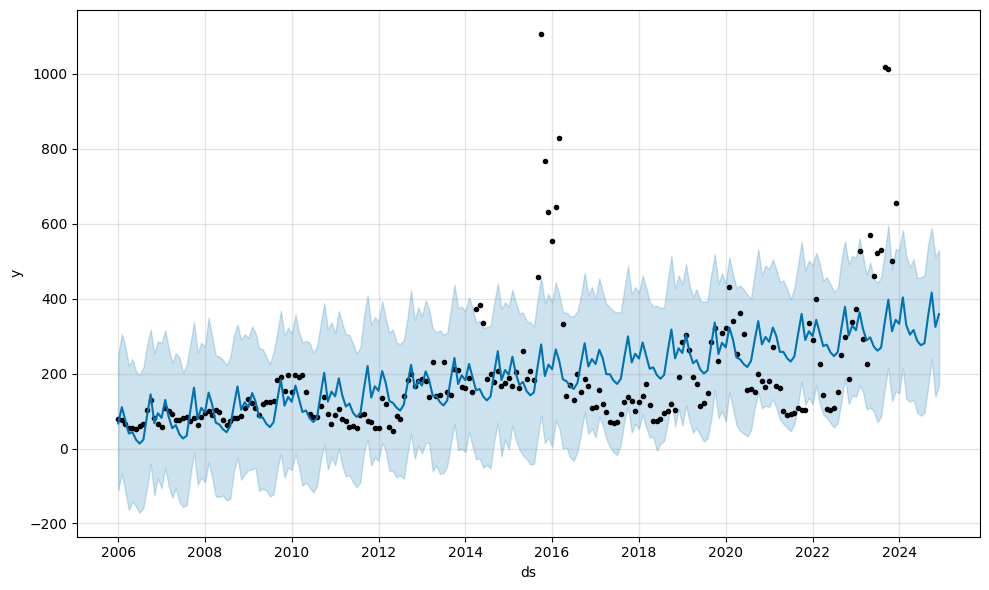

In [9]:
# Graficar los resultados
model_ph.plot(forecast_ph)
plt.show()

c:\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the 

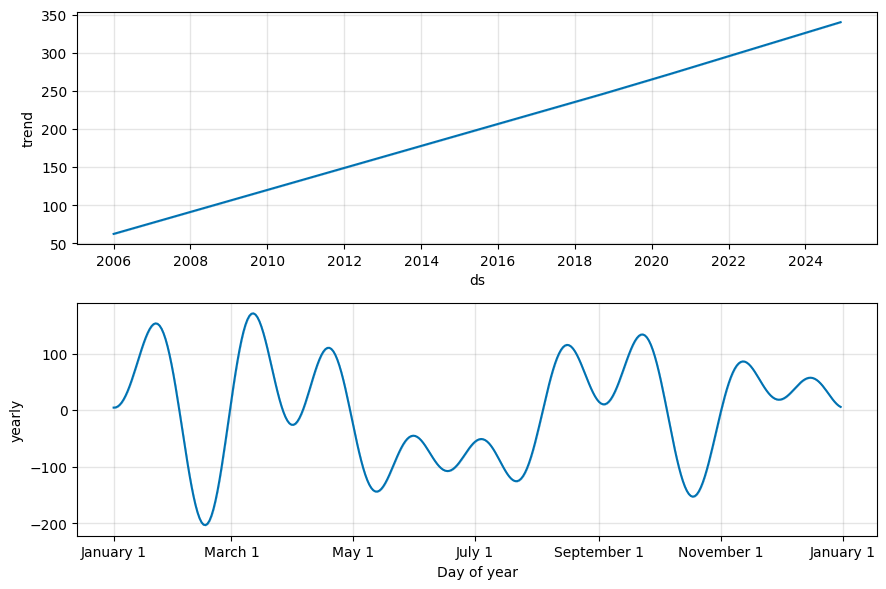

In [10]:
# Graficar los componentes de la predicción
model_ph.plot_components(forecast_ph)
plt.show()

#### 6.3.2.5 Conclusión

El uso del modelo Prophet nos permite no solo ajustar nuestros datos históricos de manera precisa, sino también proyectar tendencias futuras con un alto grado de confianza. Este enfoque integral facilita la toma de decisiones informadas basadas en datos, permitiendo a la organización anticiparse a cambios y planificar estratégicamente.

In [11]:
# transformación de la predicción para gráfico de modelos
forecast_ph_pred = forecast_ph.copy()

cond = forecast_ph_pred['ds'] > datetime(2023,12,1)

forecast_ph_pred = forecast_ph_pred[cond]

### 6.3.4 Comparación de modelos

En esta sección, se llevará a cabo una comparación detallada entre tres modelos de series de tiempo: Prophet, ARIMA y Holt-Winters (ETS). El objetivo es evaluar el rendimiento de cada modelo en la predicción de los últimos 12 meses de la serie temporal.

#### 6.3.4.1 Modelo ARIMA

El modelo ARIMA (AutoRegressive Integrated Moving Average) es una técnica ampliamente utilizada para el análisis y predicción de series de tiempo. Este modelo combina tres componentes: autorregresivo (AR), diferenciación (I) y media móvil (MA), permitiendo capturar diversas características de la serie temporal como tendencias y patrones estacionales. A continuación, se describe el proceso de ajuste y predicción utilizando el modelo ARIMA.

Ajuste del modelo ARIMA:

- Se ajusta un modelo ARIMA configurado con parámetros específicos, determinados a partir de análisis previos de los datos.
- Se generan predicciones para los próximos 12 meses, incluyendo intervalos de confianza para evaluar la precisión de las predicciones.

In [12]:
# Ajustar un modelo ARIMA(4,1,3) a la serie temporal, usando los parámetros sugeridos por los gráficos ACF y PACF
model_ar = ARIMA(df_vcm['valor'].dropna(), order=(4, 1, 3))
model_ar = model_ar.fit()

# Mostrar el resumen del modelo ajustado
model_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  valor   No. Observations:                  216
Model:                 ARIMA(4, 1, 3)   Log Likelihood               -1271.589
Date:                Sun, 23 Jun 2024   AIC                           2559.179
Time:                        20:09:08   BIC                           2586.144
Sample:                             0   HQIC                          2570.074
                                - 216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3596      0.073    -18.499      0.000      -1.504      -1.216
ar.L2         -1.4133      0.110    -12.866      0.000      -1.629      -1.198
ar.L3         -0.9801      0.097    -10.062      0.000      -1.171      -0.789
ar.L4         -0.5078      0.042    -12.003      0.000      -0.591      -0.425
ma.L1          1.2854      0.086     14.867      0.000       1.116       1.455
ma.L2          1.0554      0.123      8.600      0.000       0.815       1.296
ma.L3          0.4069      0.122      3.333      0.001       0.168       0.646
sigma2      7977.5712    437.381     18.239      0.000    7120.321    8834.822
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1789.29
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              19.45   Skew:                             2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Hacer predicciones con el modelo ARIMA ajustado para los próximos 12 períodos
forecast_12 = model_ar.get_forecast(steps=12)
forecast_conf_int_12 = forecast_12.conf_int()

# Crear un DataFrame para visualizar las predicciones y los intervalos de confianza para 24 meses
forecast_ar = pd.DataFrame({
    'Predicted': forecast_12.predicted_mean,
    'Lower CI': forecast_conf_int_12.iloc[:, 0],
    'Upper CI': forecast_conf_int_12.iloc[:, 1]
})

forecast_ar

,Predicted,Lower CI,Upper CI
216,798.637263,623.578669,973.695857
217,909.751949,671.188779,1148.315120
218,709.861276,444.123132,975.599420
219,605.610642,322.970210,888.251073
220,848.230423,544.215010,1152.245836
221,805.189217,456.522034,1153.856400
222,724.485897,358.304220,1090.667574
223,710.196025,329.526408,1090.865642
224,762.662996,359.652211,1165.673781
225,812.477166,388.151557,1236.802776


#### 6.3.4.2 Modelo Holt-Winters (ETS)

El modelo Holt-Winters, también conocido como ETS (Error, Trend, Seasonal), es una metodología eficaz para la predicción de series de tiempo que presentan tendencias y estacionalidades. Este modelo utiliza componentes aditivos o multiplicativos para capturar la variabilidad en los datos, proporcionando una estructura flexible y precisa para el análisis temporal. A continuación, se describe el proceso de ajuste y predicción utilizando el modelo Holt-Winters.

Ajuste del modelo Holt-Winters (ETS):

- Se aplica el método Holt-Winters a los datos, utilizando componentes aditivos para capturar tanto la tendencia como la estacionalidad.
- Se generan predicciones para los próximos 12 meses, ofreciendo una visión anticipada del comportamiento futuro de la serie temporal.

In [14]:
# Crear una serie temporal
precio_ts = pd.Series(df_vcm['valor'].values, index=pd.date_range(start='2006-01', periods=len(df_vcm), freq='M'))

# Estabilización de la variabilidad
preciolog = np.log(precio_ts)

# Aplicación del método Holt-Winters
model_hw = ExponentialSmoothing(preciolog, seasonal_periods=12, trend='add', seasonal='add')
fit_hw = model_hw.fit()

# Predicción del siguiente año
forecast_hw = fit_hw.forecast(steps=12)
forecast_hw = np.exp(forecast_hw)

forecast_hw

2024-01-31    682.405436
2024-02-29    849.408270
2024-03-31    719.570056
2024-04-30    614.322265
2024-05-31    553.492579
2024-06-30    516.287423
2024-07-31    491.847869
2024-08-31    561.084371
2024-09-30    704.403964
2024-10-31    824.921868
2024-11-30    659.444182
2024-12-31    730.551716
Freq: M, dtype: float64

#### 6.3.4.3 Visualización de Pronósticos de los modelos

En esta etapa, se procederá a la visualización comparativa de las predicciones obtenidas de los modelos Prophet, ARIMA y Holt-Winters (ETS). Esta visualización es para evaluar la precisión y el desempeño de cada modelo en relación con los datos reales. Además, se incluirán intervalos de confianza para las predicciones de Prophet y ARIMA, permitiendo así una comprensión más completa de la incertidumbre asociada a estas estimaciones.

- Se crea un gráfico que compara las predicciones de los tres modelos con los datos reales.
- Se incluyen intervalos de confianza para las predicciones de Prophet y ARIMA para evaluar la incertidumbre de las predicciones.

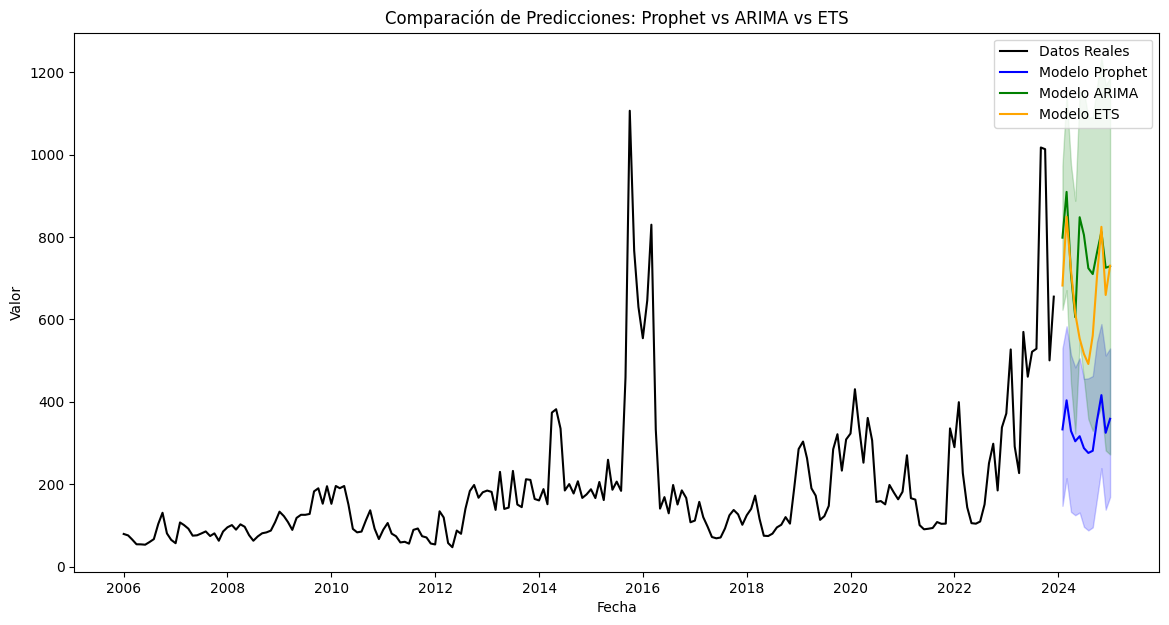

In [15]:
# Crear el gráfico comparativo
plt.figure(figsize=(14, 7))

prediction_dates_12 = pd.date_range(start=df_vcm['fechaoperacion'].iloc[-1] + pd.DateOffset(months=1), periods=12, freq='M')

# Datos reales
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Datos Reales', color='black')

# Predicciones Prophet
plt.plot(pd.date_range(start='2024-01', periods=12, freq='M'), forecast_ph_pred['yhat'], label='Modelo Prophet', color='blue')
plt.fill_between(pd.date_range(start='2024-01', periods=12, freq='M'), forecast_ph_pred['yhat_lower'], forecast_ph_pred['yhat_upper'], color='blue', alpha=0.2)

# Predicciones ARIMA
plt.plot(prediction_dates_12, forecast_ar['Predicted'], label='Modelo ARIMA', color='green')
plt.fill_between(prediction_dates_12, forecast_ar['Lower CI'], forecast_ar['Upper CI'], color='green', alpha=0.2)

# Predicciones ETS
plt.plot(pd.date_range(start='2024-01', periods=12, freq='M'), forecast_hw, label='Modelo ETS', color='orange')

# Formatear el gráfico
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Comparación de Predicciones: Prophet vs ARIMA vs ETS')
plt.legend()
plt.show()

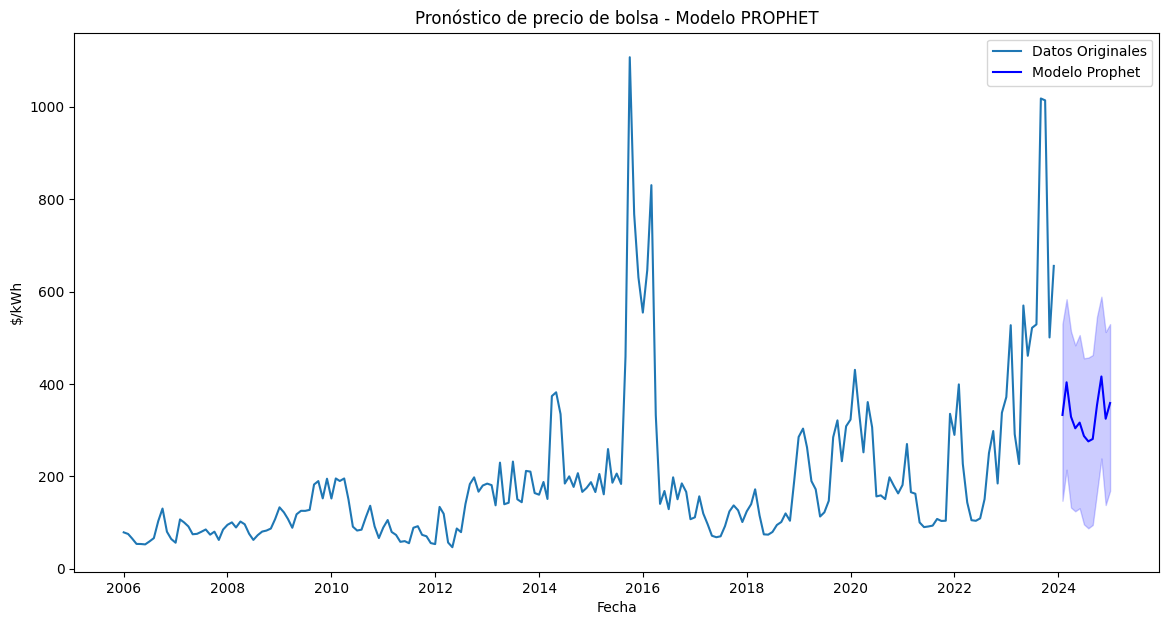

In [17]:
# Crear el gráfico comparativo
plt.figure(figsize=(14, 7))

# Datos reales
plt.plot(df_vcm['fechaoperacion'], df_vcm['valor'], label='Datos Originales')

# Predicciones Prophet
plt.plot(pd.date_range(start='2024-01', periods=12, freq='M'), forecast_ph_pred['yhat'], label='Modelo Prophet', color='blue')
plt.fill_between(pd.date_range(start='2024-01', periods=12, freq='M'), forecast_ph_pred['yhat_lower'], forecast_ph_pred['yhat_upper'], color='blue', alpha=0.2)

# Formatear el gráfico
plt.xlabel('Fecha')
plt.ylabel('$/kWh')
plt.title('Pronóstico de precio de bolsa - Modelo PROPHET')
plt.legend()
plt.show()